In [13]:
import os
import pickle
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt

from openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [16]:
class DataPlotter(object):
    
    def __init__(self, d_labels_to_info):
        """
        Parameters
        ----------
        d_labels_to_info : OrderedDict()
            contains free energy data for each experiment
            key : name of experiment (format: '{single letter amino acid of WT}{residue id}{single letter amino acid of mutant} 
                                                {phase} ({simulation type} r{replicate number})')
            value : dict with the following keys:
                key : list of file path(s) to free energy data
                key : list of starting indices to use in slicing the free energy data
                key : list of ending indices to use in slicing the free energy data
                key : total iterations to analyze 
            
            example: 
            d_labels_to_info = OrderedDict({
                "A42T complex (AREX r1)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [50],
                                               "total_iterations": 50000,
                                              }
                })
        """
        # Set unsampled state indices
        self.first_unsampled_state_index = 0
        self.last_unsampled_state_index = -1
        
        # Load data
        data = OrderedDict()
        for i, (label, d_info) in enumerate(d_labels_to_info.items()):
            
            file_paths = d_info["file_paths"]
            slice_begs = d_info["slice_begs"]
            slice_ends = d_info["slice_ends"]
            total_iterations = d_info["total_iterations"]
            
            # Load free energy matrices at each time point
            for j, (file_path, slice_beg, slice_end) in enumerate(zip(file_paths, slice_begs, slice_ends)):
                
                if j == 0:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label] = {"results": results[slice_beg:slice_end]}
                
                else:
                    with open(file_path, "rb") as f:
                        results = pickle.load(f)
                    data[label]["results"] += results[slice_beg:slice_end]
            
            data[label]["total_iterations"] = total_iterations
                
        self.data = data
        
        # Set colors
        self.colors = ["#80b1d3", "#fdb462", "#b3de69"]
        
    def _generate_free_energy_timeseries_plot(self, 
                                              restraints=False, 
                                              show_legend=False, 
                                              show_true_free_energy=True, 
                                              y_axis_min=None, 
                                              y_axis_max=None, 
                                              average=False, 
                                              true_dg=None,
                                              skip_replicate_label=False, 
                                              figsize=None,
                                              save_path=None):
        """
        Generate $\Delta G$ timeseries plot 
        
        Parameters
        ----------
        restraints : boolean, default False
            whether experiment involves restraints
        show_legend : boolean, default False
            whether to show the legend
        show_true_free_energy : boolean, default True
            whether to show the "true" free energy (aka `true_dg`) as a horizontal line
        y_axis_min : float, default None
            minimum value for the y axis
        y_axis_max : float, default None
            maximum value for the y axis
        average : boolean, default False
            whether to take the average across replicates
        true_dg : float, default None
            the "true" free energy
            if None, will use the free energy of the last time point
        skip_replicate_label : boolean, default False
            whether to skip inclusion of the replicate number in the label for the timeseries
        figsize : tuple of ints, default None
            dimensions to use for generating the figure
        save_path : str
            filepath at which to save the figure
        """
        
        # Set default for y_axis_mean
        y_axis_mean = -1e6
    
        # Set figure size
        if not figsize:
            figsize = (8, 4)
        fig, axes = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=figsize)
        
        # Assemble data
        dgs_all = {} # key : replicate, value: free energy timeseries
        ddgs_all = {} # key : replicate, value: uncertainty timeseries
        labels = [] # label for each simulation type
        for i, (label, data) in enumerate(self.data.items()):
            
            # Retrieve label
            title = label.split("(")[0][:-1]
            experiment_label = label.split("(")[-1][:-1]
            replicate = experiment_label[-1]
            simulation_type = experiment_label[:-3]
            if simulation_type not in labels:
                labels.append(simulation_type)
            
            # Retrieve x values (time points)
            x = np.array(range(1000, data["total_iterations"] + 1, 1000)) / 1000
    
            # Retrieve y values (free energies in kcal/mol)
            dgs = np.array([t["Deltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results"]])
            ddgs = np.array([t["dDeltaf"][self.first_unsampled_state_index, self.last_unsampled_state_index] * KT_KCALMOL for t in data["results"]])
            
            # Store the timeseries 
            if replicate not in dgs_all:
                dgs_all[replicate] = [dgs]
                ddgs_all[replicate] = [ddgs]
            else:
                dgs_all[replicate].append(dgs)
                ddgs_all[replicate].append(ddgs)
                
        # Get averages across replicates
        dgs_all_arr = np.array([dgs_all[r] for r in dgs_all])
        ddgs_all_arr = np.array([ddgs_all[r] for r in ddgs_all])
        dgs_means = []
        ddgs_means = []
        for i in range(len(labels)):
            dgs_means.append(np.mean(dgs_all_arr[:, i], axis=0))
            ddgs_means.append(np.mean(ddgs_all_arr[:, i], axis=0))
                 
        # Set font size
        plt.rc('font', size=20) 
        
        # Set colors for restraint plots
        if restraints:
            self.colors = [self.colors[0], self.colors[2]]
        
        # Plot
        if average:
            for i, (y, yerr, label) in enumerate(zip(dgs_means, ddgs_means, labels)):
                axes.plot(x, y, label=label, color=self.colors[i])
                axes.fill_between(x, y - (2 * yerr), y + (2 * yerr), color=self.colors[i], alpha=0.5)
                print(f"free energy: {y}")
                print(f"stderr: {yerr}")
                
                # Determine y axis mean
                y_mean = np.mean(y)
                if y_mean > y_axis_mean:
                    y_axis_mean = y_mean
        
        else:
            linestyles = ["solid", "dotted", "dashed"]
            for i, label in enumerate(labels):
                for replicate in dgs_all:
                    y = dgs_all[replicate][i]
                    if restraints:
                        final_dg = y[-1]
                        y = [dg - final_dg for dg in y] # compute residual DG
                    yerr = ddgs_all[replicate][i]
                    label_final = f"{label}" if skip_replicate_label else f"{label} r{replicate}"
                    axes.plot(x, y, label=label_final, color=self.colors[i], linestyle=linestyles[int(replicate)])
                    axes.fill_between(x, y - (2 * yerr), y + (2 * yerr), color=self.colors[i], alpha=0.5)
                    print(f"free energy: {y}")
                    print(f"stderr: {yerr}")
                    
                    # Determine y axis mean
                    y_mean = np.mean(y)
                    if y_mean > y_axis_mean:
                        y_axis_mean = y_mean
        
        # Handle legend
        if show_legend:
            if average or restraints:
                axes.legend()
            else:
                axes.legend(ncol=2)
        
        # Set x and y axis labels
        if restraints:
            #y_label = r"Residual $\Delta G_\mathrm{complex}$ (kcal/mol)"
            y_label = r"Residual $\Delta G$ (kcal/mol)"
        else:
            y_label = r"$\Delta G$ (kcal/mol)"
        axes.set_ylabel(y_label)
        axes.set_xlabel("t (ns)")
        
        # Set x and y limits
        if not y_axis_min:
            y_axis_min = round(y_axis_mean) - 6
        if not y_axis_max:
            y_axis_max = round(y_axis_mean) + 8
        plt.yticks(np.arange(y_axis_min, y_axis_max, 2.0))
        total_ns = int(data["total_iterations"] / 1000)
        if total_ns == 10 or total_ns == 5:
            plt.xticks(np.arange(1, total_ns + 1, 1.0))
        else:
            plt.xticks([1] +  list(np.arange(10, total_ns + 1, 10.0)))
            
        # Plot true free energy or last free energy
        if show_true_free_energy:
            if true_dg: # Use the user-specified true_free_energy, if specified
                axes.axhline(y=true_dg, linestyle='dotted', linewidth=3, color=self.colors[0])
            else: # Otherwise, take the last free energy in the plot
                for i, true_dg in enumerate(dgs_means):
                    if i == 0:
                        axes.axhline(y=true_dg[-1], linestyle='dotted', linewidth=3, color=self.colors[i])
        
        # Set title
        axes.set_title(title)
        
        # Ensure x-axis labels are not cut off
        plt.tight_layout()

        # Save plot as pdf
        if save_path:
            plt.savefig(save_path, dpi=500)
            plt.show()
            plt.clf()
        else:
            plt.show()
        


# Barnase:barstar

## AREX without restraints

### Complex 10 ns

free energy: [-28.98003638 -29.60274969 -30.17589097 -30.69322985 -31.09090856
 -31.39080318 -31.58976273 -31.73922857 -31.80268329 -31.94320631]
stderr: [0.29295161 0.22563684 0.1738571  0.1621124  0.13854467 0.12496072
 0.10637687 0.09278557 0.10318132 0.095366  ]


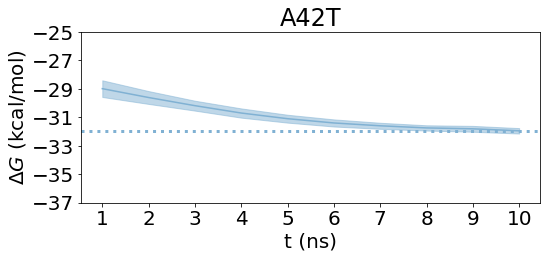

free energy: [115.37925243 114.38997625 113.59907921 112.88209231 112.57279225
 112.14460891 111.81093411 111.25784827 110.82270806 110.41641139]
stderr: [1.0780834  0.85855991 0.73256366 0.60955173 0.58206393 0.52789308
 0.4555634  0.45745515 0.42113866 0.44453056]


<Figure size 432x288 with 0 Axes>

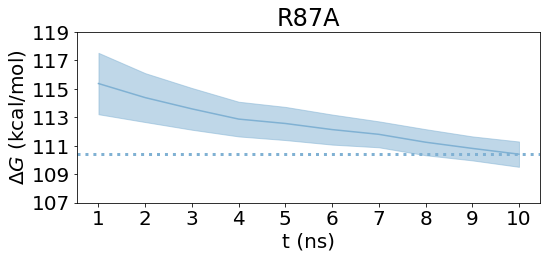

free energy: [-0.32584319 -0.38211311 -0.3848679  -0.44231746 -0.44464732 -0.34913378
 -0.36882992 -0.33491661 -0.29403323 -0.27165809]
stderr: [0.79172587 0.60427827 0.55750774 0.50528184 0.40996709 0.35513142
 0.37312374 0.32620418 0.34494911 0.32002013]


<Figure size 432x288 with 0 Axes>

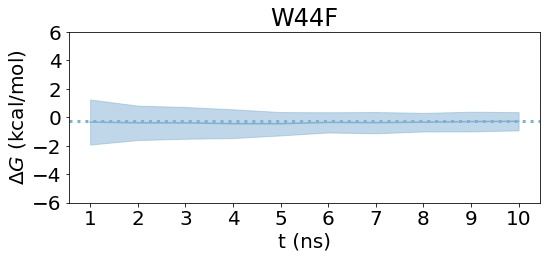

<Figure size 432x288 with 0 Axes>

In [5]:
main_dir = 45
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"

sub_dirs = [9, 10, 11]
mutations = ["A42T", "R87A", "W44F"]

for sub_dir, mutation in zip(sub_dirs, mutations):
    if sub_dir in [9, 10]:
        replicate = 1
    else: 
        replicate = 0
    
    filename = f"{phase}_free_energy_timeseries_1_50ns.pickle"
    d_labels_to_info = OrderedDict({
                        f"{mutation} (no rest r0)": {"file_paths": # note that we use r0, not r1 here because its the first curve (so we want the linestyle to be solid)
                                                       [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                   "slice_begs": [0],
                                                   "slice_ends": [10],
                                                   "total_iterations": 10000,
                                                  },
                        })

    save_path = os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", f"{sub_dir}_{phase}_series_10ns.pdf")
    data_plotter = DataPlotter(d_labels_to_info)
    data_plotter._generate_free_energy_timeseries_plot(show_true_free_energy=True, save_path=save_path)


### Apo 10 ns

free energy: [-31.9480247  -32.04350263 -32.3187434  -32.45326583 -32.55045772
 -32.64086655 -32.71395684 -32.70314871 -32.72979839 -32.74575721]
stderr: [0.34703758 0.26665445 0.21807401 0.16931758 0.15881579 0.17163018
 0.14088964 0.15337826 0.13981484 0.12750205]


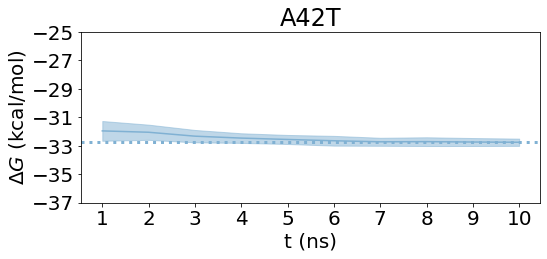

free energy: [100.60121548  99.88616483  99.68480101  99.69153255  99.7204172
  99.55519104  99.4583554   99.38441049  99.23408511  99.26882187]
stderr: [1.29812919 1.08864052 0.97856581 0.86551133 0.77994967 0.73147934
 0.65016817 0.59385979 0.64203737 0.4831454 ]


<Figure size 432x288 with 0 Axes>

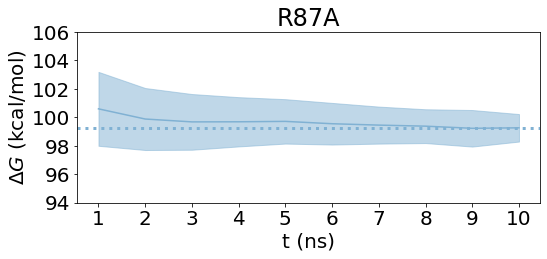

free energy: [-0.49672233 -0.44488036 -0.3786391  -0.38251393 -0.34366304 -0.40323362
 -0.43428517 -0.46535154 -0.47175153 -0.4095259 ]
stderr: [0.748236   0.55975776 0.50393461 0.45593395 0.41509492 0.34779049
 0.33263622 0.34154256 0.34368831 0.28462606]


<Figure size 432x288 with 0 Axes>

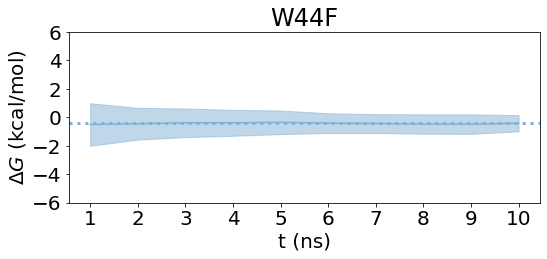

<Figure size 432x288 with 0 Axes>

In [4]:
main_dir = 45
phase = 'apo'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"

sub_dirs = [9, 10, 11]
mutations = ["A42T", "R87A", "W44F"]

for sub_dir, mutation in zip(sub_dirs, mutations):
    if sub_dir in [9, 10]:
        replicate = 1
    else:
        replicate = 0
    
    filename = f"{phase}_free_energy_timeseries_1_10ns.pickle"

    d_labels_to_info = OrderedDict({
                        f"{mutation} (no rest r0)": {"file_paths": # note that we use r0, not r1 here because its the first curve (so we want the linestyle to be solid)
                                                       [os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", filename)],
                                                   "slice_begs": [0],
                                                   "slice_ends": [10],
                                                   "total_iterations": 10000,
                                                  },
                        })

    if mutation == 'A42T':
        y_axis_min = -37
        y_axis_max = -24
    else:
        y_axis_min = None
        y_axis_max = None
    
    save_path = os.path.join(base_path, str(sub_dir), f"replicate_{replicate}", f"{sub_dir}_{phase}_series_10ns.pdf")
    data_plotter = DataPlotter(d_labels_to_info)
    data_plotter._generate_free_energy_timeseries_plot(show_true_free_energy=True, 
                                                       y_axis_min=y_axis_min,
                                                       y_axis_max=y_axis_max,
                                                       save_path=save_path)


## AREX with restraints

### Complex 10 ns

free energy: [2.9631699297227634, 2.3404566207944804, 1.7673153327257225, 1.2499764618940858, 0.8522977432483323, 0.5524031246535621, 0.3534435744521893, 0.2039777380669463, 0.14052302026978936, 0.0]
stderr: [0.29295161 0.22563684 0.1738571  0.1621124  0.13854467 0.12496072
 0.10637687 0.09278557 0.10318132 0.095366  ]
free energy: [0.24910741468512043, 0.09116482122260194, 0.025951965742361693, -0.05834807042739243, -0.134065113961352, -0.09608567198708329, -0.08058330454319318, -0.05489711730287894, -0.0300814392759996, 0.0]
stderr: [0.32936721 0.2281235  0.20601182 0.17368126 0.14142616 0.14003692
 0.12592022 0.11779727 0.11488519 0.1094514 ]


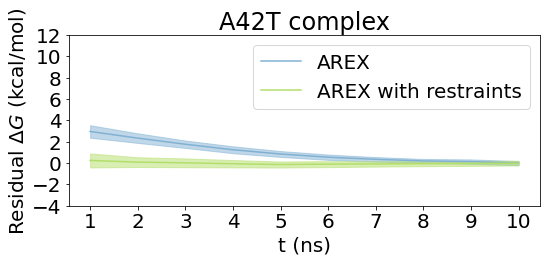

free energy: [4.962841036514263, 3.973564858491997, 3.1826678151113867, 2.465680915673815, 2.156380855288077, 1.728197518669461, 1.394522720163053, 0.8414368781192252, 0.40629667177603324, 0.0]
stderr: [1.0780834  0.85855991 0.73256366 0.60955173 0.58206393 0.52789308
 0.4555634  0.45745515 0.42113866 0.44453056]
free energy: [7.484250152248634, 6.057426302967983, 4.400284892304967, 2.8147851462267113, 1.7360169612412335, 0.8241054088399267, 0.336209968497883, 0.3801501116065822, 0.17685037426034, 0.0]
stderr: [1.71723875 1.31951417 1.1090058  0.92238808 0.87868497 0.76017274
 0.79789334 0.73037565 0.6537847  0.64276752]


<Figure size 432x288 with 0 Axes>

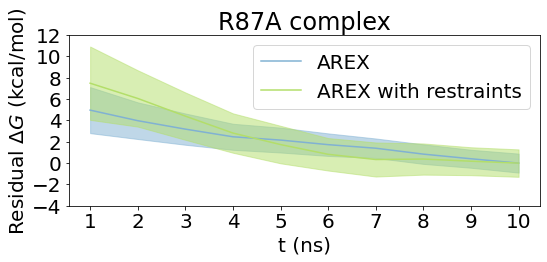

<Figure size 432x288 with 0 Axes>

In [12]:
main_dir = 45
main_dir_restraints = 48
phase = 'complex'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
base_path_restraints = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir_restraints}/"

# A42T
sub_dir = "9"
sub_dir_restraints = "0"
d_labels_to_info = OrderedDict({
                    "A42T complex (AREX r0)": {"file_paths": # note that we use r0, not r1 here because the replicate number needs to match across the two experiments
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    "A42T complex (AREX with restraints r0)": {"file_paths": 
                                                   [os.path.join(base_path_restraints, sub_dir_restraints, "replicate_0", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    })

save_path = os.path.join(base_path_restraints, sub_dir_restraints, "replicate_0", f"{sub_dir_restraints}_{phase}_series_10ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(restraints=True, show_legend=True, show_true_free_energy=False, y_axis_min=-4, y_axis_max=14, skip_replicate_label=True, save_path=save_path)


# R87A
sub_dir = "10"
sub_dir_restraints = "1"
d_labels_to_info = d_labels_to_info = OrderedDict({
                    "R87A complex (AREX r0)": {"file_paths": 
                                                   [os.path.join(base_path, sub_dir, "replicate_1", f"{phase}_free_energy_timeseries_1_50ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                     "R87A complex (AREX with restraints r0)": {"file_paths": 
                                                   [os.path.join(base_path_restraints, sub_dir_restraints, "replicate_0", f"{phase}_free_energy_timeseries_1_10ns.pickle")],
                                               "slice_begs": [0],
                                               "slice_ends": [10],
                                               "total_iterations": 10000,
                                              },
                    })

save_path = os.path.join(base_path_restraints, sub_dir_restraints, "replicate_0", f"{sub_dir_restraints}_{phase}_series_10ns.pdf")
data_plotter = DataPlotter(d_labels_to_info)
data_plotter._generate_free_energy_timeseries_plot(restraints=True, show_legend=True, show_true_free_energy=False, y_axis_max=14, skip_replicate_label=True, save_path=save_path)


# Terminally-blocked amino acids

## ACE-X-NME (5 ns AREX)

free energy: [-31.181172   -31.15985082 -31.13819231 -31.12427066 -31.10175529]
stderr: [0.39717098 0.27960172 0.23223677 0.22610783 0.16655959]


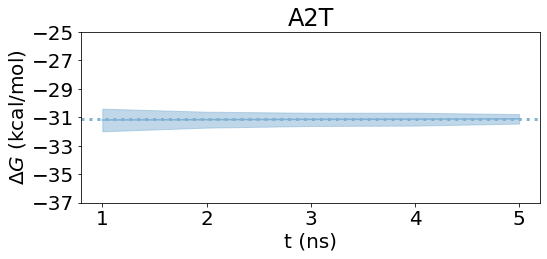

free energy: [91.50711566 91.94601701 91.96311062 91.97058844 91.92218491]
stderr: [1.87372531 1.44797175 1.31102406 1.23326397 1.08513288]


<Figure size 432x288 with 0 Axes>

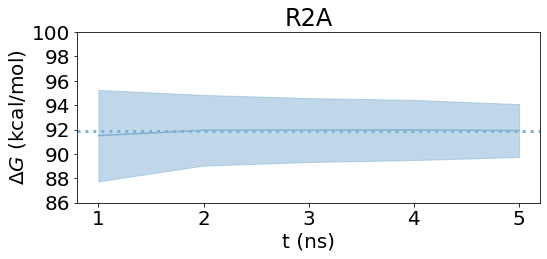

<Figure size 432x288 with 0 Axes>

In [7]:
main_dir = 46
phase = 'apo'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
filename = f"{phase}_free_energy_timeseries_1_5ns.pickle"

# A->T
sub_dir = "13"
d_labels_to_ids = OrderedDict({
                    "A2T (r0)": {"file_paths": [os.path.join(base_path, sub_dir, "replicate_0", filename)],
                                   "slice_begs": [0],
                                   "slice_ends": [5],
                                   "total_iterations": 5000,}
                  })

save_path = os.path.join(base_path, sub_dir, "replicate_0", f"{sub_dir}_{phase}_series_5ns.pdf")
data_plotter = DataPlotter(d_labels_to_ids)
data_plotter._generate_free_energy_timeseries_plot(save_path=save_path)

# R->T
sub_dir = "7"
d_labels_to_ids = OrderedDict({
                    "R2A (r0)": {"file_paths": [os.path.join(base_path, sub_dir, "replicate_0", filename)],
                                   "slice_begs": [0],
                                   "slice_ends": [5],
                                   "total_iterations": 5000,}                  
                  })

save_path = os.path.join(base_path, sub_dir, "replicate_0", f"{sub_dir}_{phase}_series_5ns.pdf")
data_plotter = DataPlotter(d_labels_to_ids)
data_plotter._generate_free_energy_timeseries_plot(save_path=save_path, y_axis_max=101)



free energy: [-31.181172   -31.15985082 -31.13819231 -31.12427066 -31.10175529]
stderr: [0.39717098 0.27960172 0.23223677 0.22610783 0.16655959]


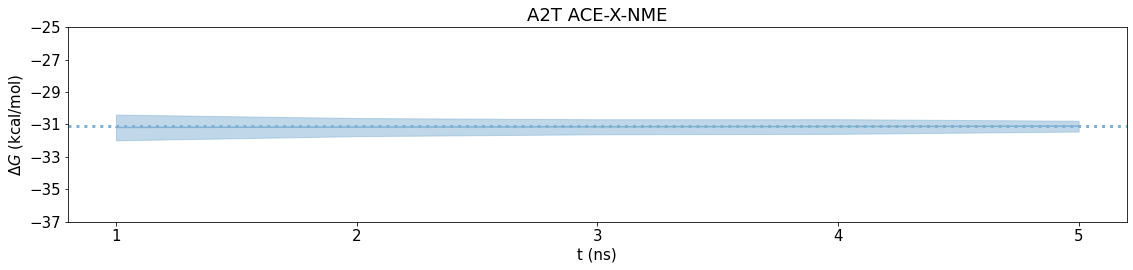

<Figure size 432x288 with 0 Axes>

In [17]:
# For free energy summary plot

main_dir = 46
phase = 'apo'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
filename = f"{phase}_free_energy_timeseries_1_5ns.pickle"

# A->T
sub_dir = "13"
d_labels_to_ids = OrderedDict({
                    "A2T ACE-X-NME (r0)": {"file_paths": [os.path.join(base_path, sub_dir, "replicate_0", filename)],
                                   "slice_begs": [0],
                                   "slice_ends": [5],
                                   "total_iterations": 5000,}
                  })

save_path = os.path.join(base_path, sub_dir, "replicate_0", f"{sub_dir}_{phase}_series_5ns_for_summary.pdf")
data_plotter = DataPlotter(d_labels_to_ids)
data_plotter._generate_free_energy_timeseries_plot(save_path=save_path,
                                                   figsize=(16, 4),
                                                  )


## ALA-X-ALA

free energy: [-30.75418976 -30.69281367 -30.54403431 -30.52813732 -30.52019264]
stderr: [0.38113933 0.27760546 0.23872908 0.21570053 0.18178644]


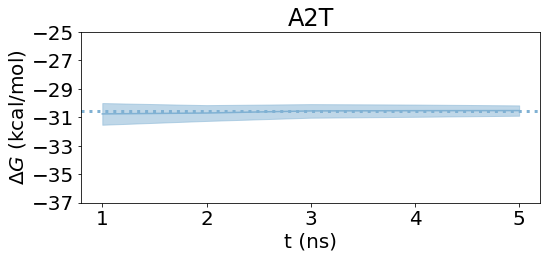

free energy: [93.1037492  93.24499297 93.35806912 93.36324421 93.38114091]
stderr: [1.97597612 1.57830213 1.55109926 1.24146749 1.13598309]


<Figure size 432x288 with 0 Axes>

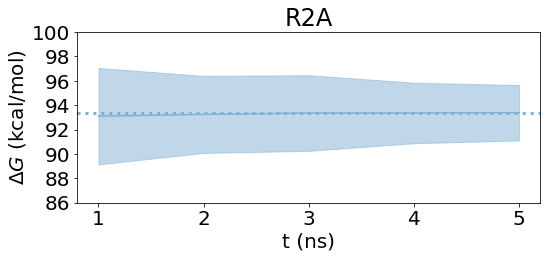

<Figure size 432x288 with 0 Axes>

In [9]:
main_dir = 46
phase = 'apo'
base_path = f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/"
filename = f"{phase}_free_energy_timeseries_1_5ns.pickle"

# A->T
sub_dir = "33"
d_labels_to_ids = OrderedDict({
                    "A2T (r0)": {"file_paths": [os.path.join(base_path, sub_dir, "replicate_0", filename)],
                                   "slice_begs": [0],
                                   "slice_ends": [5],
                                   "total_iterations": 5000,}
                  })

save_path = os.path.join(base_path, sub_dir, "replicate_0", f"{sub_dir}_{phase}_series_5ns.pdf")
data_plotter = DataPlotter(d_labels_to_ids)
data_plotter._generate_free_energy_timeseries_plot(save_path=save_path)

# R->T
sub_dir = "27"
d_labels_to_ids = OrderedDict({
                    "R2A (r0)": {"file_paths": [os.path.join(base_path, sub_dir, "replicate_0", filename)],
                                   "slice_begs": [0],
                                   "slice_ends": [5],
                                   "total_iterations": 5000,}                  
                  })

save_path = os.path.join(base_path, sub_dir, "replicate_0", f"{sub_dir}_{phase}_series_5ns.pdf")
data_plotter = DataPlotter(d_labels_to_ids)
data_plotter._generate_free_energy_timeseries_plot(save_path=save_path, y_axis_min=86)

